In [1]:
%matplotlib inline

In [2]:
from math import pi
from scipy.linalg import hadamard
from scipy.signal.windows import dpss
from matplotlib import pyplot as plt
from scipy.optimize import minimize

# pennylane/autgrad numpy
import pennylane.numpy as np
import pennylane as qml

#### hacked pennylane code
# new single qubit op
from pennylane.ops.qubit import RotXY
# modified device to support RotXY
from pennylane import device 
# modified template with RotXY as op
from pennylane.templates.layers import StronglyEntanglingLayersRotXY

# the og
import numpy as onp

In [3]:
# define some observables 
obs = [
  qml.PauliX(1),
  qml.PauliZ(1),
  qml.PauliX(0) @ qml.PauliX(1),
  qml.PauliY(0) @ qml.PauliY(1),
  qml.PauliZ(0) @ qml.PauliZ(1)
]

# num layers must be power of 2 for Walsh/Hadamard basis
num_layers = 2**4

# number of qubits 
num_wires  = 5

### RotXY $= \exp(-0.5i (\theta_x X + \theta_y Y))$

In [4]:
# RotXY is the new single qubit op
RotXY(*np.random.rand(2),wires=[0]).matrix

tensor([[ 0.84859307+0.j        , -0.40454749-0.34092688j],
        [ 0.40454749-0.34092688j,  0.84859307+0.j        ]], requires_grad=True)

In [5]:
## MODIFIED default.qubit device to add custom operation "RotXY"
dev = qml.device("default.qubit", wires=num_wires, analytic=True)

# Map our ansatz over our list of observables,
qnodes = qml.map(StronglyEntanglingLayersRotXY, obs, device=dev)

# choose a circuit/obs from qnodes list
circuit = qnodes[4]

# strongly_entangling_rotxy template requires:
# 2 parameters for each RotXY for each layer and each wire
theta_tape = np.random.rand(num_layers,num_wires, 2)

# create circuit
circuit(theta_tape)

# print circuit ... its big
#print(circuit.draw())

tensor(0.18609389, requires_grad=True)

## Walsh/Hadamard Basis Functions

In [6]:
# Walsh/Hadamard basis functions (columns)
# Hadamards are square
# take one less column for dimension counting/sanity
V = hadamard(num_layers)[:,:-1]
num_basis_functions = V.shape[1]
print('number of basis functions: %d'%num_basis_functions)

number of basis functions: 15


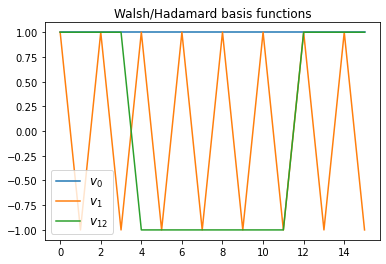

In [7]:
fs = 12
plt.plot(V[:,0], label='$v_0$');
plt.plot(V[:,1], label='$v_1$');
plt.plot(V[:,12],label='$v_{12}$');
plt.title('Walsh/Hadamard basis functions',fontsize=fs)
plt.legend(loc='lower left', fontsize=fs);

## Basis function Coefficients

In [8]:
# initialize some random coefficients
alpha_init = onp.random.rand(num_basis_functions,num_wires,2)
print('alpha shape: (%d, %d, %d) (num_basis_functions, num_wires, num_ops)'%(alpha_init.shape))

alpha shape: (15, 5, 2) (num_basis_functions, num_wires, num_ops)


## Global --> Local transform 
## $ {\cal A} \to \Theta: \quad  {\cal V} \otimes_k {\cal A}= \Theta  $
### $\theta_{l j x} = \sum_k v_{lk} \alpha_{jkx}$

In [9]:
theta_init = np.tensordot(V,alpha_init,([1],[0]))
theta_init.shape

(16, 5, 2)

## Functional Gradient Descent

In [10]:
# GRAFS functions

def grafs_circuit(_alpha):
    # transform global (alpha) --> local (theta)
    theta_ = onp.tensordot(V,_alpha,([1],[0]))
    # evaluate the circuit
    return circuit(theta_)

def grafs_grad(_alpha):
    # alpha --> theta
    theta_ = onp.tensordot(V,_alpha,([1],[0]))
    # compute gradient wrt theta with pennylane/autograd
    cc = qml.grad(circuit)(theta_)[0]
    # complete the chain-rule to get gradient wrt alpha
    return onp.tensordot(V,cc,([0],[0]))

def grafs_step(_alpha,lr):
    # gradient step in function space
    return _alpha - lr*grafs_grad(_alpha)

# raveled GRAFS functions for scipy BFGS

def grafs_circuit_ravel(_alpha_ravel, _circuit):
    # transform global (alpha) --> local (theta)
    alpha_ = onp.reshape(_alpha_ravel, (num_basis_functions,num_wires,2), order='F')
    theta_ = onp.tensordot(V,alpha_,([1],[0]))
    # evaluate the circuit
    return _circuit(theta_)

def grafs_grad_ravel(_alpha_ravel, _circuit):
    alpha_ = onp.reshape(_alpha_ravel, (num_basis_functions,num_wires,2), order='F')
    # alpha --> theta
    theta_ = onp.tensordot(V,alpha_,([1],[0]))
    # compute gradient wrt theta with pennylane/autograd
    cc = qml.grad(_circuit)(theta_)[0]
    # complete the chain-rule to get gradient wrt alpha
    return onp.tensordot(V,cc,([0],[0])).ravel(order='F')

In [11]:
steps = 35
learning_rate = 0.01

# vanilla gradient descent
opt = qml.GradientDescentOptimizer(learning_rate)

# natural gradient optimizer
# lam is a regularization parameter
opt_ng = qml.QNGOptimizer(learning_rate, lam=0.01)

# alpha --> theta
theta = np.tensordot(V,alpha_init,([1],[0]))

# for natural gradient
theta_ng = theta

gd_cost = []
qng_cost = []
grafs_cost = []

# initial cost
gd_cost.append(circuit(theta))
qng_cost.append(circuit(theta))
grafs_cost.append(grafs_circuit(alpha_init))

alpha = alpha_init

for _ in range(steps):
    #print('%f : %f' %(gd_cost[-1],grafs_cost[-1]))

    # take a theta step
    theta = opt.step(circuit, theta)
    gd_cost.append(circuit(theta))

    # take an alpha step
    alpha = grafs_step(alpha,learning_rate)
    grafs_cost.append(grafs_circuit(alpha))

    # take a natural gradient step
    theta_ng = opt_ng.step(circuit, theta_ng)
    qng_cost.append(circuit(theta_ng))

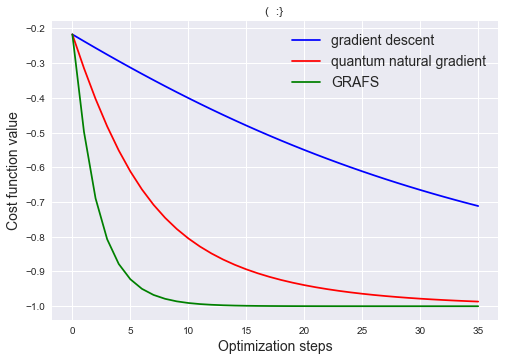

In [12]:
fs = 14
plt.style.use("seaborn")
plt.plot(gd_cost, "b", label="gradient descent")
plt.plot(qng_cost,'r', label="quantum natural gradient")
plt.plot(grafs_cost, "g", label="GRAFS")

plt.ylabel("Cost function value",fontsize=fs)
plt.xlabel("Optimization steps", fontsize=fs)
plt.title("(  :} ")
plt.legend(fontsize=fs);

## Deeper Circuits

In [13]:
# let's add more layers and extend the circuit
num_layers = 2**6

theta_tape = np.random.rand(num_layers,num_wires, 2)

# create circuit
circuit(theta_tape)

# Walsh/Hadamard basis
V = hadamard(num_layers)[:,:-1]

In [33]:
num_basis_functions = V.shape[1]
alpha_init = onp.random.rand(num_basis_functions,num_wires,2)
alpha = alpha_init

In [34]:
# this deeper circuit takes a while
# comment out qng to speed things up.

steps = 35

theta = np.tensordot(V,alpha_init,([1],[0]))
theta_ng = theta

gd_cost2 = []
grafs_cost2 = []
qng_cost2 = [] 

# initial cost
gd_cost2.append(circuit(theta))
grafs_cost2.append(grafs_circuit(alpha_init))
qng_cost2.append(circuit(theta))

for _ in range(steps):
    #print('%f : %f' %(gd_cost[-1],grafs_cost[-1]))

    # take a theta step
    theta = opt.step(circuit, theta)
    gd_cost2.append(circuit(theta))

    # take an alpha step
    alpha = grafs_step(alpha,learning_rate)
    grafs_cost2.append(grafs_circuit(alpha))

    # take a natural gradient step
    #theta_ng = opt_ng.step(circuit, theta_ng)
    #qng_cost2.append(circuit(theta_ng))

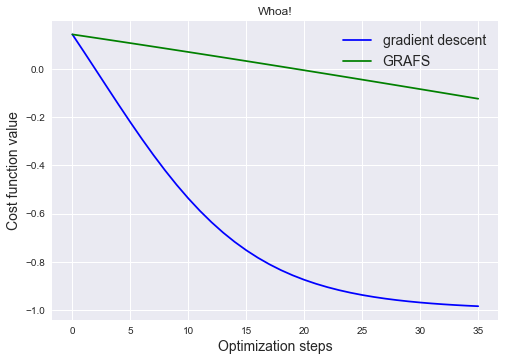

In [35]:
fs = 14
plt.style.use("seaborn")
plt.plot(gd_cost2, "b", label="gradient descent")
#plt.plot(qng_cost2,'r', label="quantum natural gradient")
plt.plot(grafs_cost2, "g", label="GRAFS")

plt.ylabel("Cost function value",fontsize=fs)
plt.xlabel("Optimization steps", fontsize=fs)
plt.title('Whoa!')
plt.legend(fontsize=fs);

## Slepian basis

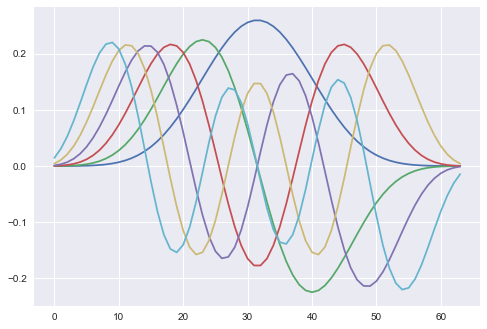

In [23]:
# dpss basis aka Slepians 
W = 0.075
NW = num_layers*W
#K = int(2*num_layers*W-1)
K = 6
Slepians = dpss(num_layers,NW,K).T
V = Slepians
plt.plot(Slepians);

## Try an adaptive learning rate with BFGS

In [37]:
def running_cost(alpha_):
    ccc = grafs_circuit_ravel(alpha_, circuit)
    #print(ccc)
    bfgs_cost.append(ccc)

bfgs_opts = {'maxiter':steps, 
             'gtol':1e-3,
             'disp':True}

lb = 0.0
ub = 1.0
boundz = [(lb,ub) for _ in range(len(alpha_init.ravel()))]

bfgs_cost = []
bfgs_cost.append(grafs_circuit_ravel(alpha_init.ravel(order='F'),circuit))
rez_bfgs = minimize(grafs_circuit_ravel, alpha_init.ravel(order='F'), bounds=boundz, jac=grafs_grad_ravel, args=(circuit), method='L-BFGS-B', options=bfgs_opts, callback=running_cost)      

print(rez_bfgs.message)
print('Num grafs iters: %d'%rez_bfgs.nit)
print('Num circuit runs: %d'%rez_bfgs.nfev)
print(rez_bfgs.fun)

alpha_opt = rez_bfgs.x.reshape(*alpha_init.shape,order='F')
theta_opt = onp.tensordot(V,alpha_opt,([1],[0]))

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
Num grafs iters: 35
Num circuit runs: 37
-0.9999762546541541


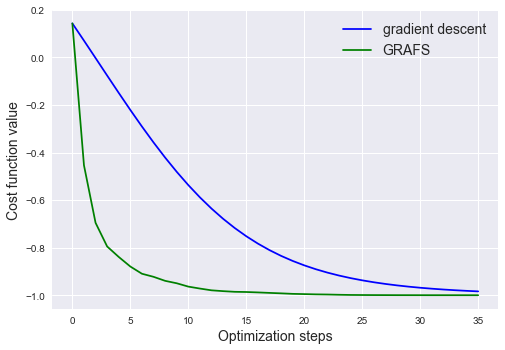

In [38]:
fs = 14
plt.style.use("seaborn")
plt.plot(gd_cost2, "b", label="gradient descent")
plt.plot(bfgs_cost, "g", label="GRAFS")

plt.ylabel("Cost function value",fontsize=fs)
plt.xlabel("Optimization steps", fontsize=fs)
plt.legend(fontsize=fs);

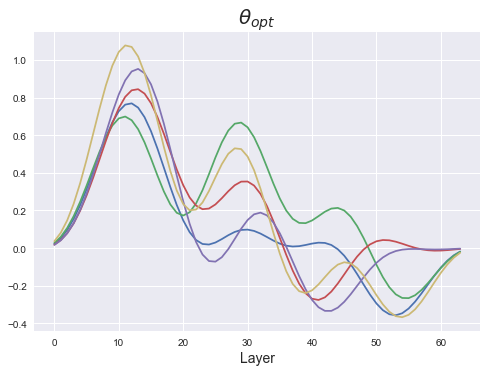

In [39]:
plt.title(r'$\theta_{opt}$', fontsize=20)
plt.xlabel('Layer', fontsize=14)
plt.plot(range(num_layers),(theta_opt[:,:,0] + theta_opt[:,:,1]));